This is a notebook to pull down all the information for figure 3 (ncbi hits). The design is to compair between each sample (barcode) instead of each flowcell as they sequenced the same thing. Therefore I just pulled all the ncbi hits for each flowcell for each barcode and merged them together according to the barcode.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import product
import argparse
from ete3 import NCBITaxa 


In [2]:
ncbi = NCBITaxa()


In [3]:
# use argparse to do this
#BASEDIR = args.BASEDIR
BASEDIR = '/home/yiheng/test'

# here we define the folder name of the dataframe it created by capturing the folder from the BASDIR
folder_name = os.path.basename(BASEDIR)
#column_name = folder_name.split('_')[-1]

In [4]:
# first check if the analysis folder is there
folder_list = 'analysis  basecalled_data  scripts  tracking  workspace'.split(' ')
for x in range(0,folder_list.count('')):
    folder_list.remove('')
#fix this test
if not set(os.listdir(os.path.abspath(BASEDIR))) == set (folder_list):
    print("Something wrong with basefolder. check it please.")

In [5]:
# get the dataframe there
dataframe = os.path.join(BASEDIR, 'analysis', 'summary_df_%s.tab' % folder_name)
sum_df = pd.read_csv(dataframe, sep='\t')

/home/yiheng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3,5,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
sum_df.columns

Index(['read_id', 'passes_filtering', 'sequence_length_template',
       'mean_qscore_template', 'barcode_arrangement', 'barcode_score', 'kit',
       'variant', 'pc_survived', 'qseqid_nt', 'sseqid_nt', 'evalue_nt',
       'length_nt', 'pident_nt', 'nident_nt', 'sacc_nt', 'staxids_nt',
       'scomnames_nt', 'read_length_pc'],
      dtype='object')

In [7]:
# fills the nan with T/F for easier handling
#sum_df.sseqid_rg.fillna(False, inplace=True)
sum_df.sseqid_nt.fillna(False, inplace=True)
# filter out the rg blast hit
#ntblasthit_reads = sum_df[(sum_df.sseqid_rg == False) & (sum_df.sseqid_nt != False) & (sum_df.passes_filtering == True) & (sum_df.pc_survived == True) & (sum_df.nl_survived == True)]
total_reads = sum_df[(sum_df.sseqid_nt != False) & (sum_df.passes_filtering == True) & (sum_df.pc_survived == True)]
ntblasthit_reads = total_reads[total_reads.sseqid_nt != False]
pd.set_option('display.max_columns', None)

#Removing unncessary columns from joint_NCBI_df_taxonomy
#I hard coded to select as it depends on what information you need
for columns in ['passes_filtering', 'sequence_length_template',
       'mean_qscore_template', 'barcode_score', 'kit',
       'variant', 'pc_survived', 'qseqid_nt', 'sseqid_nt', 'evalue_nt',
       'length_nt', 'pident_nt', 'nident_nt', 'sacc_nt', 'scomnames_nt', 'read_length_pc']:
    del total_reads[columns] 

In [8]:
###########This block for barcodes order
# now everything left is what we want to plot out
# arrange different barcodes
# REMEMBER: This need to be manual check:

total_reads_barcode05 = total_reads[total_reads.barcode_arrangement == 'barcode05']
total_reads_barcode06 = total_reads[total_reads.barcode_arrangement == 'barcode06']
total_reads_barcode07 = total_reads[total_reads.barcode_arrangement == 'barcode07']

In [9]:
# now just filter out all the reads that are not going to used for ploting
barcode05_total = total_reads[total_reads.barcode_arrangement.str.contains('barcode05')]
barcode06_total = total_reads[total_reads.barcode_arrangement.str.contains('barcode06')]
barcode07_total = total_reads[total_reads.barcode_arrangement.str.contains('barcode07')]

# now concat them together. but remember that the index has to change to add the column for ncbi taxa
total_reads_filtered_barcodes = pd.concat([barcode05_total, 
                                           barcode06_total, 
                                           barcode07_total], ignore_index=True)

In [10]:
total_reads_filtered_barcodes.staxids_nt.fillna(False, inplace=True)
ntblasthit_reads_filtered_barcodes = total_reads_filtered_barcodes[(total_reads_filtered_barcodes.staxids_nt != False)]

In [11]:
ntblasthit_reads_filtered_barcodes = ntblasthit_reads_filtered_barcodes.reset_index(drop=True)

In [12]:
# as the concate before will result the staxid into a string
# so now change the string back to float so it can be recognized by the NCBITaxa
for taxid in ntblasthit_reads_filtered_barcodes['staxids_nt']:
    if ';' in str(taxid):
        taxid = taxid.split(';')[0]

    else:
        pass
    float(taxid)

In [13]:
#Function to generate taxonomy columns based on NCBITaxa results for NCBI hit dataframe, 
def search_rank_output_name_append_column(df, staxid_column, rank_search):
    """Input df, staxid_column from same df and rank_search (a desired taxonomic rank 
    from each staxid's lineage), outputs taxonomic name corresponding to rank_search or 'Unclassified' if
    unavailable and appends to df row by row"""
    rank_list = []
    for read_index in range(0, len(staxid_column)):
        taxid = ''
        if ';' in str(staxid_column[read_index]):
            taxid = staxid_column[read_index].split(';')[0]
################# BE CAREFUL HERE !!! #######################################
            df.loc[staxid_column =='71426;73839', 'staxids_nt'] = 73839
        else:
            taxid = staxid_column[read_index]
        
        
        taxid_lineage = ''
        taxid_lineage = ncbi.get_lineage(taxid)
        
        names = ''
        names = ncbi.get_taxid_translator(taxid_lineage)
        
        ranks = ''
        ranks = ncbi.get_rank(taxid_lineage) #Dict
        
        ranks2names = ''
        ranks2names = {ranks[k]:names[k] for k in names.keys() & ranks}
        
        if rank_search in ranks2names.keys():
            rank_list.append(ranks2names[rank_search])#if rank in dict, print name
        else:
            rank_list.append('Unclassified')
    df[rank_search] = rank_list
# NOTE: Appending is always slow, try and find a better way e.g df.apply to a column based on staxids column


In [14]:
ncbi.get_lineage(291364)
ncbi.get_lineage(1635066)
ncbi.get_lineage(72029)
ncbi.get_lineage(251300)
ncbi.get_lineage(332405)
ncbi.get_lineage(1916993)
ncbi.get_lineage(595593)
ncbi.get_lineage(71426)
ncbi.get_lineage(291364)
ncbi.get_lineage(278968)
ncbi.get_lineage(73839)
ncbi.get_lineage(38483)
ncbi.get_lineage(112484)
print(ncbi.get_lineage(9606))

[1, 131567, 2759, 33154, 33208, 6072, 33213, 33511, 7711, 89593, 7742, 7776, 117570, 117571, 8287, 1338369, 32523, 32524, 40674, 32525, 9347, 1437010, 314146, 9443, 376913, 314293, 9526, 314295, 9604, 207598, 9605, 9606]


/home/yiheng/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 291364 was translated into 2231603
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/yiheng/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 1635066 was translated into 1508258
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/yiheng/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 72029 was translated into 1836592
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/yiheng/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 251300 was translated into 332405
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/yiheng/anaconda3/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: U

In [15]:
ncbi.get_rank([1969666])

{}

In [16]:
ncbi.get_taxid_translator('40674')

{6: 'Azorhizobium', 7: 'Azorhizobium caulinodans'}

In [17]:
# see above, some taxids are changed (translated) sometimes, which is probably due to the version of the local nt database.
# therefore, here I mannualy adjusted all the taxids that has been changed to the new numbers.

ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='291364', 'staxids_nt'] = 2231603
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='1635066', 'staxids_nt'] = 1508258
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='72029', 'staxids_nt'] = 1836592
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='251300', 'staxids_nt'] = 332405
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='652050', 'staxids_nt'] = 2204306
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='1916993', 'staxids_nt'] = 303
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='595593', 'staxids_nt'] = 656366
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='71426;73839', 'staxids_nt'] = 73839
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='278968', 'staxids_nt'] = 2025498
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='38483', 'staxids_nt'] = 1436886
ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='112484', 'staxids_nt'] = 1431917
# the taxdb was changed and this taxid was removed and untracked
ntblasthit_reads_filtered_barcodes = ntblasthit_reads_filtered_barcodes[ntblasthit_reads_filtered_barcodes.staxids_nt!='1969666']
ntblasthit_reads_filtered_barcodes = ntblasthit_reads_filtered_barcodes.reset_index(drop=True)
#ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='278968', 'staxids_nt'] = 2025498
#ntblasthit_reads_filtered_barcodes.loc[ntblasthit_reads_filtered_barcodes.staxids_nt=='71426', 'staxids_nt'] = 1915362


In [18]:
ntblasthit_reads_filtered_barcodes.index[ntblasthit_reads_filtered_barcodes.staxids_nt.str.contains('811799') == True]

Int64Index([], dtype='int64')

In [19]:
ntblasthit_reads_filtered_barcodes[ntblasthit_reads_filtered_barcodes.staxids_nt.str.contains('1431917') == True]

,read_id,barcode_arrangement,staxids_nt


In [ ]:
search_rank_output_name_append_column(ntblasthit_reads_filtered_barcodes, 
                                        ntblasthit_reads_filtered_barcodes.staxids_nt, 
                                          'superkingdom')

In [ ]:
search_rank_output_name_append_column(ntblasthit_reads_filtered_barcodes, 
                                        ntblasthit_reads_filtered_barcodes.staxids_nt, 
                                          'phylum')

In [ ]:
search_rank_output_name_append_column(ntblasthit_reads_filtered_barcodes, 
                                        ntblasthit_reads_filtered_barcodes.staxids_nt, 
                                          'class')

In [ ]:
search_rank_output_name_append_column(ntblasthit_reads_filtered_barcodes, 
                                        ntblasthit_reads_filtered_barcodes.staxids_nt, 
                                          'order')

In [20]:
#ntblasthit_reads_filtered_barcodes_added_TaxaRank = ntblasthit_reads_filtered_barcodes.copy()
# pretty slow
rank_list = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for rank in rank_list:
    search_rank_output_name_append_column(ntblasthit_reads_filtered_barcodes, 
                                          ntblasthit_reads_filtered_barcodes.staxids_nt, 
                                          rank)

KeyboardInterrupt: 

In [ ]:
# add the flowcell column just in case
#ntblasthit_reads_filtered_barcodes = ntblasthit_reads_filtered_barcodes.assign(Flowcell = column_name)
#total_reads_filtered_barcodes = total_reads_filtered_barcodes.assign(Flowcell = column_name)

In [17]:
#total_reads_filtered_barcodes.to_csv(r'/home/yiheng/analysis/WGS/%s_totaltaxa.tab' % column_name, header=column_name, index=None, sep='\t')
#ntblasthit_reads_filtered_barcodes.to_csv(r'/home/yiheng/analysis/WGS/%s_nttaxa.tab' % column_name, header=column_name, index=None, sep='\t')

In [18]:
#Defines a function to make manual adjustments to the NCBI taxonomic sorting
def manually_adjust_ncbi_taxonomy(rank_select, entry_select, ranks_to_edit, new_entry):
    """Select dataframe entries to edit by a specific rank (rank_select) 
    and entry related to that rank (entry_select), 
    provide a list of ranks to edit for those selected entries (ranks_to_edit),
    replace these ranks with a new entry (new_entry)"""
    if entry_select in list(ntblasthit_reads_filtered_barcodes[rank_select].unique()):
        selection = (ntblasthit_reads_filtered_barcodes[rank_select] == entry_select)
        selected_tax_ranks = ranks_to_edit
        for ranks in selected_tax_ranks:
            ntblasthit_reads_filtered_barcodes[ranks][selection] = new_entry

In [19]:
#manually_adjust_ncbi_taxonomy('species', 
#                            'Cloning vector lambda TXF97', 
#                            ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus'], 
#                            'Cloning vector lambda TXF97')

#manually_adjust_ncbi_taxonomy('superkingdom', 
#                            'Viruses', 
#                            ['phylum', 'class'], 
#                            'dsDNA viruses, no RNA stage')

In [33]:
#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='read_id', 
                                            index=rank, 
                                            columns='barcode_arrangement', 
                                            aggfunc='count', 
                                            fill_value=0)
    pivot_table.columns.name = None
    pivot_table = pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)
    return pivot_table

In [34]:
generate_ncbi_taxonomy_pivot(ntblasthit_reads_filtered_barcodes, 'genus','barcode07', 10)

KeyError: 'genus'

In [22]:
total_no_of_each_barcode_df = pd.DataFrame({'barcode01':len(total_reads_filtered_barcodes[total_reads_filtered_barcodes.barcode_arrangement == 'barcode01']),
                                            'barcode02':len(total_reads_filtered_barcodes[total_reads_filtered_barcodes.barcode_arrangement == 'barcode02']),
                                            'barcode03':len(total_reads_filtered_barcodes[total_reads_filtered_barcodes.barcode_arrangement == 'barcode03']),
                                            'barcode04':len(total_reads_filtered_barcodes[total_reads_filtered_barcodes.barcode_arrangement == 'barcode04']),
                                            'barcode05':len(total_reads_filtered_barcodes[total_reads_filtered_barcodes.barcode_arrangement == 'barcode05'])}, index = [0])

In [23]:
total_no_of_each_barcode_df

,barcode01,barcode02,barcode03,barcode04,barcode05
0,42133,70120,30148,2443,4597


In [24]:
pivot_df = generate_ncbi_taxonomy_pivot(ntblasthit_reads_filtered_barcodes, 'genus','barcode04',10)

In [25]:
# % pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_pc(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank %, sorted ascending by bcs"""
    pivot_table_pc = generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num)
    
    for ind, brcs in enumerate(pivot_table_pc.columns):
        pivot_table_pc[str(brcs) + '%'] = pivot_table_pc[brcs].apply(lambda x: (x / total_no_of_each_barcode_df.iloc[0,ind])*100)
    for brcs in pivot_table_pc.columns:
        if '%' not in brcs:
            pivot_table_pc.drop(brcs, axis=1, inplace=True)
    

    pivot_table_pc2 = pivot_table_pc.sort_values(str(bcs) + '%', axis=0, ascending=False)
    return pivot_table_pc2.applymap(lambda x: '%.3f' % x).head(n=num)

In [26]:
generate_ncbi_taxonomy_pivot_pc(ntblasthit_reads_filtered_barcodes, 'genus', 'barcode03', 20)

,barcode01%,barcode02%,barcode03%,barcode04%,barcode05%
genus,,,,,
Triticum,0.000,0.001,0.007,0.000,0.000
Sus,0.000,0.000,0.003,0.041,0.000
Alternaria,0.009,0.158,0.003,0.041,0.065
Monopterus,0.000,0.000,0.003,0.000,0.000
Panthera,0.000,0.000,0.003,0.000,0.000
Hordeum,0.000,0.000,0.003,0.000,0.000
Helobdella,0.000,0.000,0.003,0.000,0.000
Hymenobacter,0.000,0.044,0.003,0.000,0.000
Exophiala,0.000,0.001,0.003,0.000,0.000


In [27]:
#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
ncbiblast_barcodes = list(ntblasthit_reads_filtered_barcodes['barcode_arrangement'].unique())
no_of_subplots = len(ncbiblast_barcodes)+1

In [28]:
#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))

In [29]:
name_list = ['Stripe rust', 'Septoria tritici blotch', 'Healthy wheat', 'Stripe rust and sptoria tritici blotch', 'Yellow spot']

In [30]:
def get_color(x):
    x = x%10
    return ('#%02X%02X%02X' % (int(plt.cm.tab10.colors[x][0]*255),int(plt.cm.tab10.colors[x][1]*255),int(plt.cm.tab10.colors[x][2]*255)))

def applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, rank, name):
    labels = ''
    labels = tuple(generate_ncbi_taxonomy_pivot_pc(ntblasthit_reads_filtered_barcodes, rank, bcs, 10)[bcs + '%'].index)
    y_pos = ''
    y_pos = np.arange(len(labels))
    sizes = ''
    sizes = tuple([float(i) for i in generate_ncbi_taxonomy_pivot_pc(ntblasthit_reads_filtered_barcodes, rank, bcs, 10)[bcs + '%']])
    
    ax[ax_ind1, ax_ind2].barh(y_pos, sizes, align='center', alpha=0.4, color=get_color(2*ax_ind2 + ax_ind1))
    ax[ax_ind1, ax_ind2].set_yticks(y_pos)
    ax[ax_ind1, ax_ind2].set_yticklabels(labels)
    ax[ax_ind1, ax_ind2].tick_params(top="off", right="off", left="off")
    ax[ax_ind1, ax_ind2].set_xlabel('% Total Reads Hitting NCBI')
    ax[ax_ind1, ax_ind2].set_xticks(range(0, 3),0.2)
    ax[ax_ind1, ax_ind2].set_title(name)
    ax[ax_ind1, ax_ind2].invert_yaxis()
    ax[ax_ind1, ax_ind2].grid(b=None, which='major', axis='x', linestyle='dashed', linewidth=0.2)
    ax[ax_ind1, ax_ind2].annotate('E = 0.00001', 
             xy=(1.06, 0.3), xycoords='axes fraction', fontsize=10, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')

    
def generateTaxSubplots(search_rank):
    for ax_ind1, ax_ind2, bcs, name in zip(subplot_coordinates_list_columns, subplot_coordinates_list_rows, ncbiblast_barcodes, name_list):
        applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, search_rank, name)    

    if len(list(ntblasthit_reads_filtered_barcodes['barcode_arrangement'].unique())) != 0:
        plt.delaxes(ax[subplot_coordinates_list_columns[-1], subplot_coordinates_list_rows[-1]])
    
    plt.suptitle('Reads Hitting NCBI Database - % By ' + str(search_rank).title() + ' By Sample', 
             fontsize='x-large',
             y=1.02,
             fontweight="bold")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.4, hspace=0.4)
    plt.tight_layout()
    
    plt.savefig('/home/yiheng/analysis/WGS/figures/' + 'figure3_%s_%s.png' % (column_name, search_rank), bbox_inches='tight')
    plt.show()
            
            


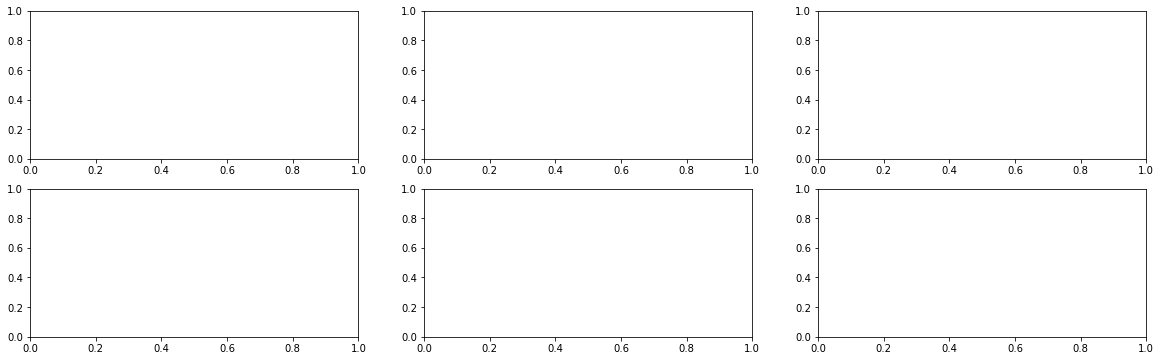

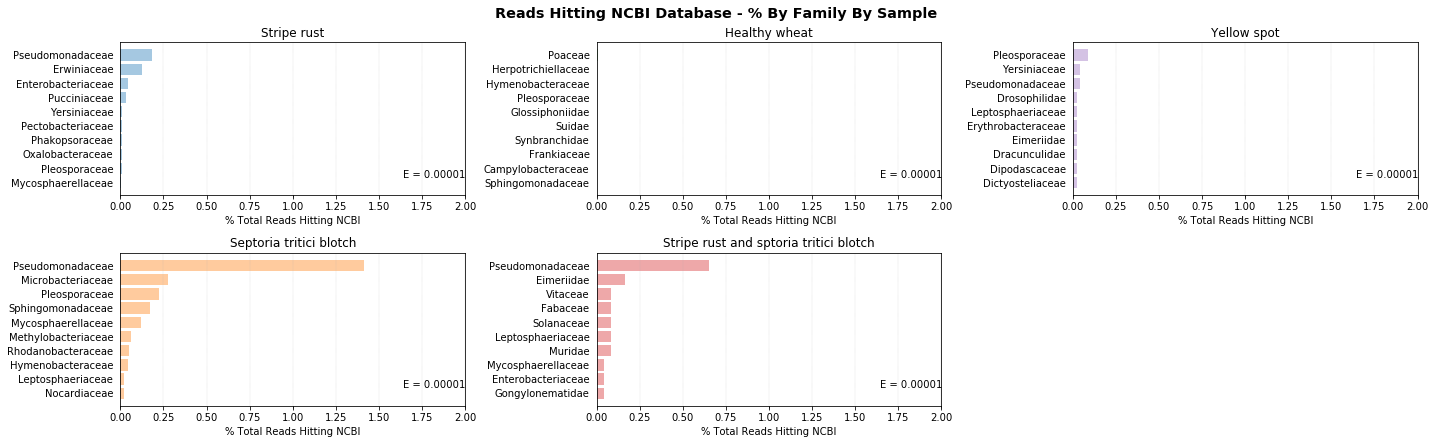

In [31]:
fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))
generateTaxSubplots('family')

In [ ]:
df1=pd.DataFrame([[1, 2],[10, 1], [3, 4], [7, 8]], columns=['A', 'B'])
df2=pd.DataFrame([[1, 4],[3, 5]], columns=['A', 'B'])
# now replace the location use the index of each df selected from value by .loc function
# first select the value from df2 column A
for values in df2['A'].unique():
    # then locate the position in df1 and replace it by the VALUE of the position in df2
    df1.loc[df1[df1['A'] == (values)].index, 'B'] = df2.loc[df2[df2['A'] == (values)].index, 'B'].values

In [ ]:
df1